<a href="https://colab.research.google.com/github/Tam107/BDM/blob/main/EE_%2B_RF_%2B_MLP_good_result.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cell 1

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.layers import Input, Dense, Embedding, Reshape, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from IPython.display import Image

print("Libraries imported successfully")

Libraries imported successfully


Cell 2: Load and Select Columns

In [13]:
cols_to_keep = [
    'price', 'brand', 'model', 'gearbox', 'kilometer', 'powerPS',
    'yearOfRegistration', 'monthOfRegistration', 'dateCreated',
    'vehicleType', 'fuelType', 'notRepairedDamage'
]
data = pd.read_csv('autos.csv', encoding='latin1', usecols=cols_to_keep)
print("5 dòng đầu tiên của dataset:")
print(data.head())
print("\nThông tin dataset:")
print(data.info())

5 dòng đầu tiên của dataset:
   price vehicleType  yearOfRegistration    gearbox  powerPS  model  \
0    480         NaN                1993    manuell        0   golf   
1  18300       coupe                2011    manuell      190    NaN   
2   9800         suv                2004  automatik      163  grand   
3   1500  kleinwagen                2001    manuell       75   golf   
4   3600  kleinwagen                2008    manuell       69  fabia   

   kilometer  monthOfRegistration fuelType       brand notRepairedDamage  \
0     150000                    0   benzin  volkswagen               NaN   
1     125000                    5   diesel        audi                ja   
2     125000                    8   diesel        jeep               NaN   
3     150000                    6   benzin  volkswagen              nein   
4      90000                    7   diesel       skoda              nein   

           dateCreated  
0  2016-03-24 00:00:00  
1  2016-03-24 00:00:00  
2  2016-03-1

Cell 3: Data Preprocessing

In [14]:
# Handle missing values
data['powerPS'] = data['powerPS'].replace(0, np.nan).fillna(data['powerPS'].median())
data['yearOfRegistration'] = data['yearOfRegistration'].replace(0, np.nan).fillna(data['yearOfRegistration'].median())
data['monthOfRegistration'] = data['monthOfRegistration'].replace(0, np.nan).fillna(data['monthOfRegistration'].median())
data['gearbox'] = data['gearbox'].fillna('manual')
data['model'] = data['model'].fillna('unknown')
data['brand'] = data['brand'].fillna('unknown')
data['vehicleType'] = data['vehicleType'].fillna('unknown')
data['fuelType'] = data['fuelType'].fillna('unknown')
data['notRepairedDamage'] = data['notRepairedDamage'].fillna('nein')

# Feature engineering
data['dateCreated'] = pd.to_datetime(data['dateCreated'])
data['adYear'] = data['dateCreated'].dt.year
data['car_age'] = data['adYear'] - data['yearOfRegistration']
data['powerPS_per_km'] = data['powerPS'] / (data['kilometer'] + 1)
data['age_km_interaction'] = data['car_age'] * data['kilometer']
data['is_damaged'] = data['notRepairedDamage'].map({'ja': 1, 'nein': 0})
data = data.drop(columns=['dateCreated', 'yearOfRegistration', 'notRepairedDamage'])

# Ensure categorical columns are strings
for col in ['brand', 'model', 'gearbox', 'vehicleType', 'fuelType']:
    data[col] = data[col].astype(str)

# Dummies for gearbox
gearbox_dummies = pd.get_dummies(data['gearbox'], prefix='gearbox')
data = pd.concat([data, gearbox_dummies], axis=1).drop('gearbox', axis=1)

# Numeric columns
numeric_cols = [col for col in data.columns if col not in ['price', 'brand', 'model', 'vehicleType', 'fuelType']]

# Filter price > 0 and take a smaller subset for debugging
data = data[data['price'] > 0].sample(n=50000, random_state=42)  # Reduced size for testing
print(f"Number of rows after filtering and sampling: {len(data)}")

# Clip outliers
for col in ['price', 'kilometer', 'powerPS', 'car_age']:
    lower_bound = data[col].quantile(0.01)
    upper_bound = data[col].quantile(0.99)
    print(f"Clipping {col}: lower_bound={lower_bound}, upper_bound={upper_bound}")
    data[col] = data[col].clip(lower=lower_bound, upper=upper_bound)

# Scale numeric features
scaler = MinMaxScaler()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

# Scale price
price_scaler = MinMaxScaler()
data['price'] = price_scaler.fit_transform(data[['price']])
print("Price Scaler Parameters:")
print(f"data_min_: {price_scaler.data_min_}")
print(f"data_max_: {price_scaler.data_max_}")

# Check for nan/inf in preprocessed data
print("NaN in data:", data.isna().sum().sum())
print("Inf in numeric cols:", np.isinf(data[numeric_cols]).sum().sum())

print("\n5 dòng đầu tiên sau khi xử lý:")
print(data.head())
print("\nThông tin dataset sau xử lý:")
print(data.info())

Number of rows after filtering and sampling: 50000
Clipping price: lower_bound=100.0, upper_bound=35999.01
Clipping kilometer: lower_bound=5000.0, upper_bound=150000.0
Clipping powerPS: lower_bound=45.0, upper_bound=340.0
Clipping car_age: lower_bound=-2.0, upper_bound=36.0
Price Scaler Parameters:
data_min_: [100.]
data_max_: [35999.01]
NaN in data: 0
Inf in numeric cols: 0

5 dòng đầu tiên sau khi xử lý:
           price vehicleType   powerPS   model  kilometer  \
44135   0.228391   limousine  0.284746     3er   0.586207   
64221   0.178250         bus  0.203390  touran   1.000000   
223484  0.357949      cabrio  0.400000     slk   0.517241   
91792   0.359314   limousine  0.138983    golf   0.172414   
73287   0.025042  kleinwagen  0.118644   punto   1.000000   

        monthOfRegistration fuelType          brand  adYear   car_age  \
44135              0.636364   benzin            bmw     1.0  0.315789   
64221              0.454545   diesel     volkswagen     1.0  0.368421   
2234

Cell 4: Train-Test Split

In [15]:
X = data.drop(['price'], axis=1).copy()
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_new, X_val, y_train_new, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(f'\nTập huấn luyện có {X_train_new.shape[0]} bản ghi và {X_train_new.shape[1]} cột.')
print(f'Tập validation có {len(X_val)} bản ghi.')
print(f'Tập kiểm tra có {len(X_test)} bản ghi.')


Tập huấn luyện có 32000 bản ghi và 15 cột.
Tập validation có 8000 bản ghi.
Tập kiểm tra có 10000 bản ghi.


Cell 5: Prepare Data and Train Random Forest

In [16]:
# Prepare data for Random Forest with one-hot encoding
X_train_rf = X_train_new.copy()
X_val_rf = X_val.copy()
X_test_rf = X_test.copy()

cat_cols = ['brand', 'model', 'vehicleType', 'fuelType']
X_train_rf = pd.get_dummies(X_train_rf, columns=cat_cols)
X_val_rf = pd.get_dummies(X_val_rf, columns=cat_cols)
X_test_rf = pd.get_dummies(X_test_rf, columns=cat_cols)

# Align columns
X_train_rf, X_val_rf = X_train_rf.align(X_val_rf, join='left', axis=1, fill_value=0)
X_train_rf, X_test_rf = X_train_rf.align(X_test_rf, join='left', axis=1, fill_value=0)
X_val_rf, X_test_rf = X_val_rf.align(X_test_rf, join='left', axis=1, fill_value=0)

# Train Random Forest
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_rf, y_train_new)

# Generate RF predictions
rf_pred_train = rf.predict(X_train_rf)
rf_pred_val = rf.predict(X_val_rf)
rf_pred_test = rf.predict(X_test_rf)

# Scale RF predictions to [0, 1]
rf_scaler = MinMaxScaler()
rf_pred_train = rf_scaler.fit_transform(rf_pred_train.reshape(-1, 1)).flatten()
rf_pred_val = rf_scaler.transform(rf_pred_val.reshape(-1, 1)).flatten()
rf_pred_test = rf_scaler.transform(rf_pred_test.reshape(-1, 1)).flatten()

# Add RF predictions as a feature
X_train_new['rf_pred'] = rf_pred_train
X_val['rf_pred'] = rf_pred_val
X_test['rf_pred'] = rf_pred_test

# Define numeric columns for inf check
numeric_cols = [col for col in X_train_new.columns if col not in ['brand', 'model', 'vehicleType', 'fuelType']]

# Robust data validation
for col in X_train_new.columns:
    if X_train_new[col].isna().sum() > 0:
        print(f"NaN found in X_train_new[{col}]: {X_train_new[col].isna().sum()}")
for col in X_train_new[numeric_cols]:
    if np.isinf(X_train_new[col]).sum() > 0:
        print(f"Inf found in X_train_new[{col}]: {np.isinf(X_train_new[col]).sum()}")

for col in X_val.columns:
    if X_val[col].isna().sum() > 0:
        print(f"NaN found in X_val[{col}]: {X_val[col].isna().sum()}")
for col in X_val[numeric_cols]:
    if np.isinf(X_val[col]).sum() > 0:
        print(f"Inf found in X_val[{col}]: {np.isinf(X_val[col]).sum()}")

print("NaN in y_train_new:", np.isnan(y_train_new).sum())
print("NaN in y_val:", np.isnan(y_val).sum())
print("Inf in y_train_new:", np.isinf(y_train_new).sum())
print("Inf in y_val:", np.isinf(y_val).sum())

print(f"Random Forest training data shape: {X_train_rf.shape}")
print(f"Random Forest validation MSE: {np.mean((y_val - rf_pred_val) ** 2):.6f}")
print(f"Random Forest validation MAE: {np.mean(np.abs(y_val - rf_pred_val)):.6f}")

NaN in y_train_new: 0
NaN in y_val: 0
Inf in y_train_new: 0
Inf in y_val: 0
Random Forest training data shape: (32000, 314)
Random Forest validation MSE: 0.005103
Random Forest validation MAE: 0.038915


Cell 6: Encode Categorical Variables for Embedding (MLP)

In [21]:
input_list_train_new = []
input_list_val = []
input_list_test = []
cat_encoders = {}
for col in ['brand', 'model', 'vehicleType', 'fuelType']:
    unique_cat = np.unique(X_train_new[col])
    cat_encoders[col] = {val: idx for idx, val in enumerate(unique_cat)}
    input_list_train_new.append(X_train_new[col].map(cat_encoders[col]).values.astype(np.int32))
    input_list_val.append(X_val[col].map(cat_encoders[col]).fillna(0).values.astype(np.int32))
    input_list_test.append(X_test[col].map(cat_encoders[col]).fillna(0).values.astype(np.int32))
    print(f'\nCó {len(unique_cat)} giá trị duy nhất trong cột {col} trong tập huấn luyện.')

numeric_cols = [col for col in X_train_new.columns if col not in ['brand', 'model', 'vehicleType', 'fuelType']]
input_list_train_new.append(X_train_new[numeric_cols].values.astype(np.float32))
input_list_val.append(X_val[numeric_cols].values.astype(np.float32))
input_list_test.append(X_test[numeric_cols].values.astype(np.float32))

# Convert y variables to NumPy arrays consistently
y_train_new = y_train_new.to_numpy().astype(np.float32)
y_val = y_val.to_numpy().astype(np.float32)
y_test = y_test.to_numpy().astype(np.float32)


Có 40 giá trị duy nhất trong cột brand trong tập huấn luyện.

Có 246 giá trị duy nhất trong cột model trong tập huấn luyện.

Có 9 giá trị duy nhất trong cột vehicleType trong tập huấn luyện.

Có 8 giá trị duy nhất trong cột fuelType trong tập huấn luyện.


Cell 7: Define Embedding Dimensions and Build Simplified MLP Model


Tóm tắt mô hình MLP:


Model: "Stacked_RF_MLP"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_6             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_7             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_8             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_4 (Embedding)   │ (None, 1, 8)           │            320 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_5 (Embedding)   │ (None, 1, 15)          │          3,690 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_6 (Embedding)   │ (None, 1, 5)           │             45 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_7 (Embedding)   │ (None, 1, 4)           │             32 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_4 (Reshape)       │ (None, 8)              │              0 │ embedding_4[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_5 (Reshape)       │ (None, 15)             │              0 │ embedding_5[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_6 (Reshape)       │ (None, 5)              │              0 │ embedding_6[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_7 (Reshape)       │ (None, 4)              │              0 │ embedding_7[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_9             │ (None, 12)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 44)             │              0 │ reshape_4[0][0],       │
│ (Concatenate)             │                        │                │ reshape_5[0][0],       │
│                           │                        │                │ reshape_6[0][0],       │
│                           │                        │                │ reshape_7[0][0],       │
│                           │                        │                │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 128)            │          5,760 │ concatenate_1[0][0]    │
├──────────────────────

 Total params: 18,936 (73.97 KB)

 Trainable params: 18,552 (72.47 KB)

 Non-trainable params: 384 (1.50 KB)

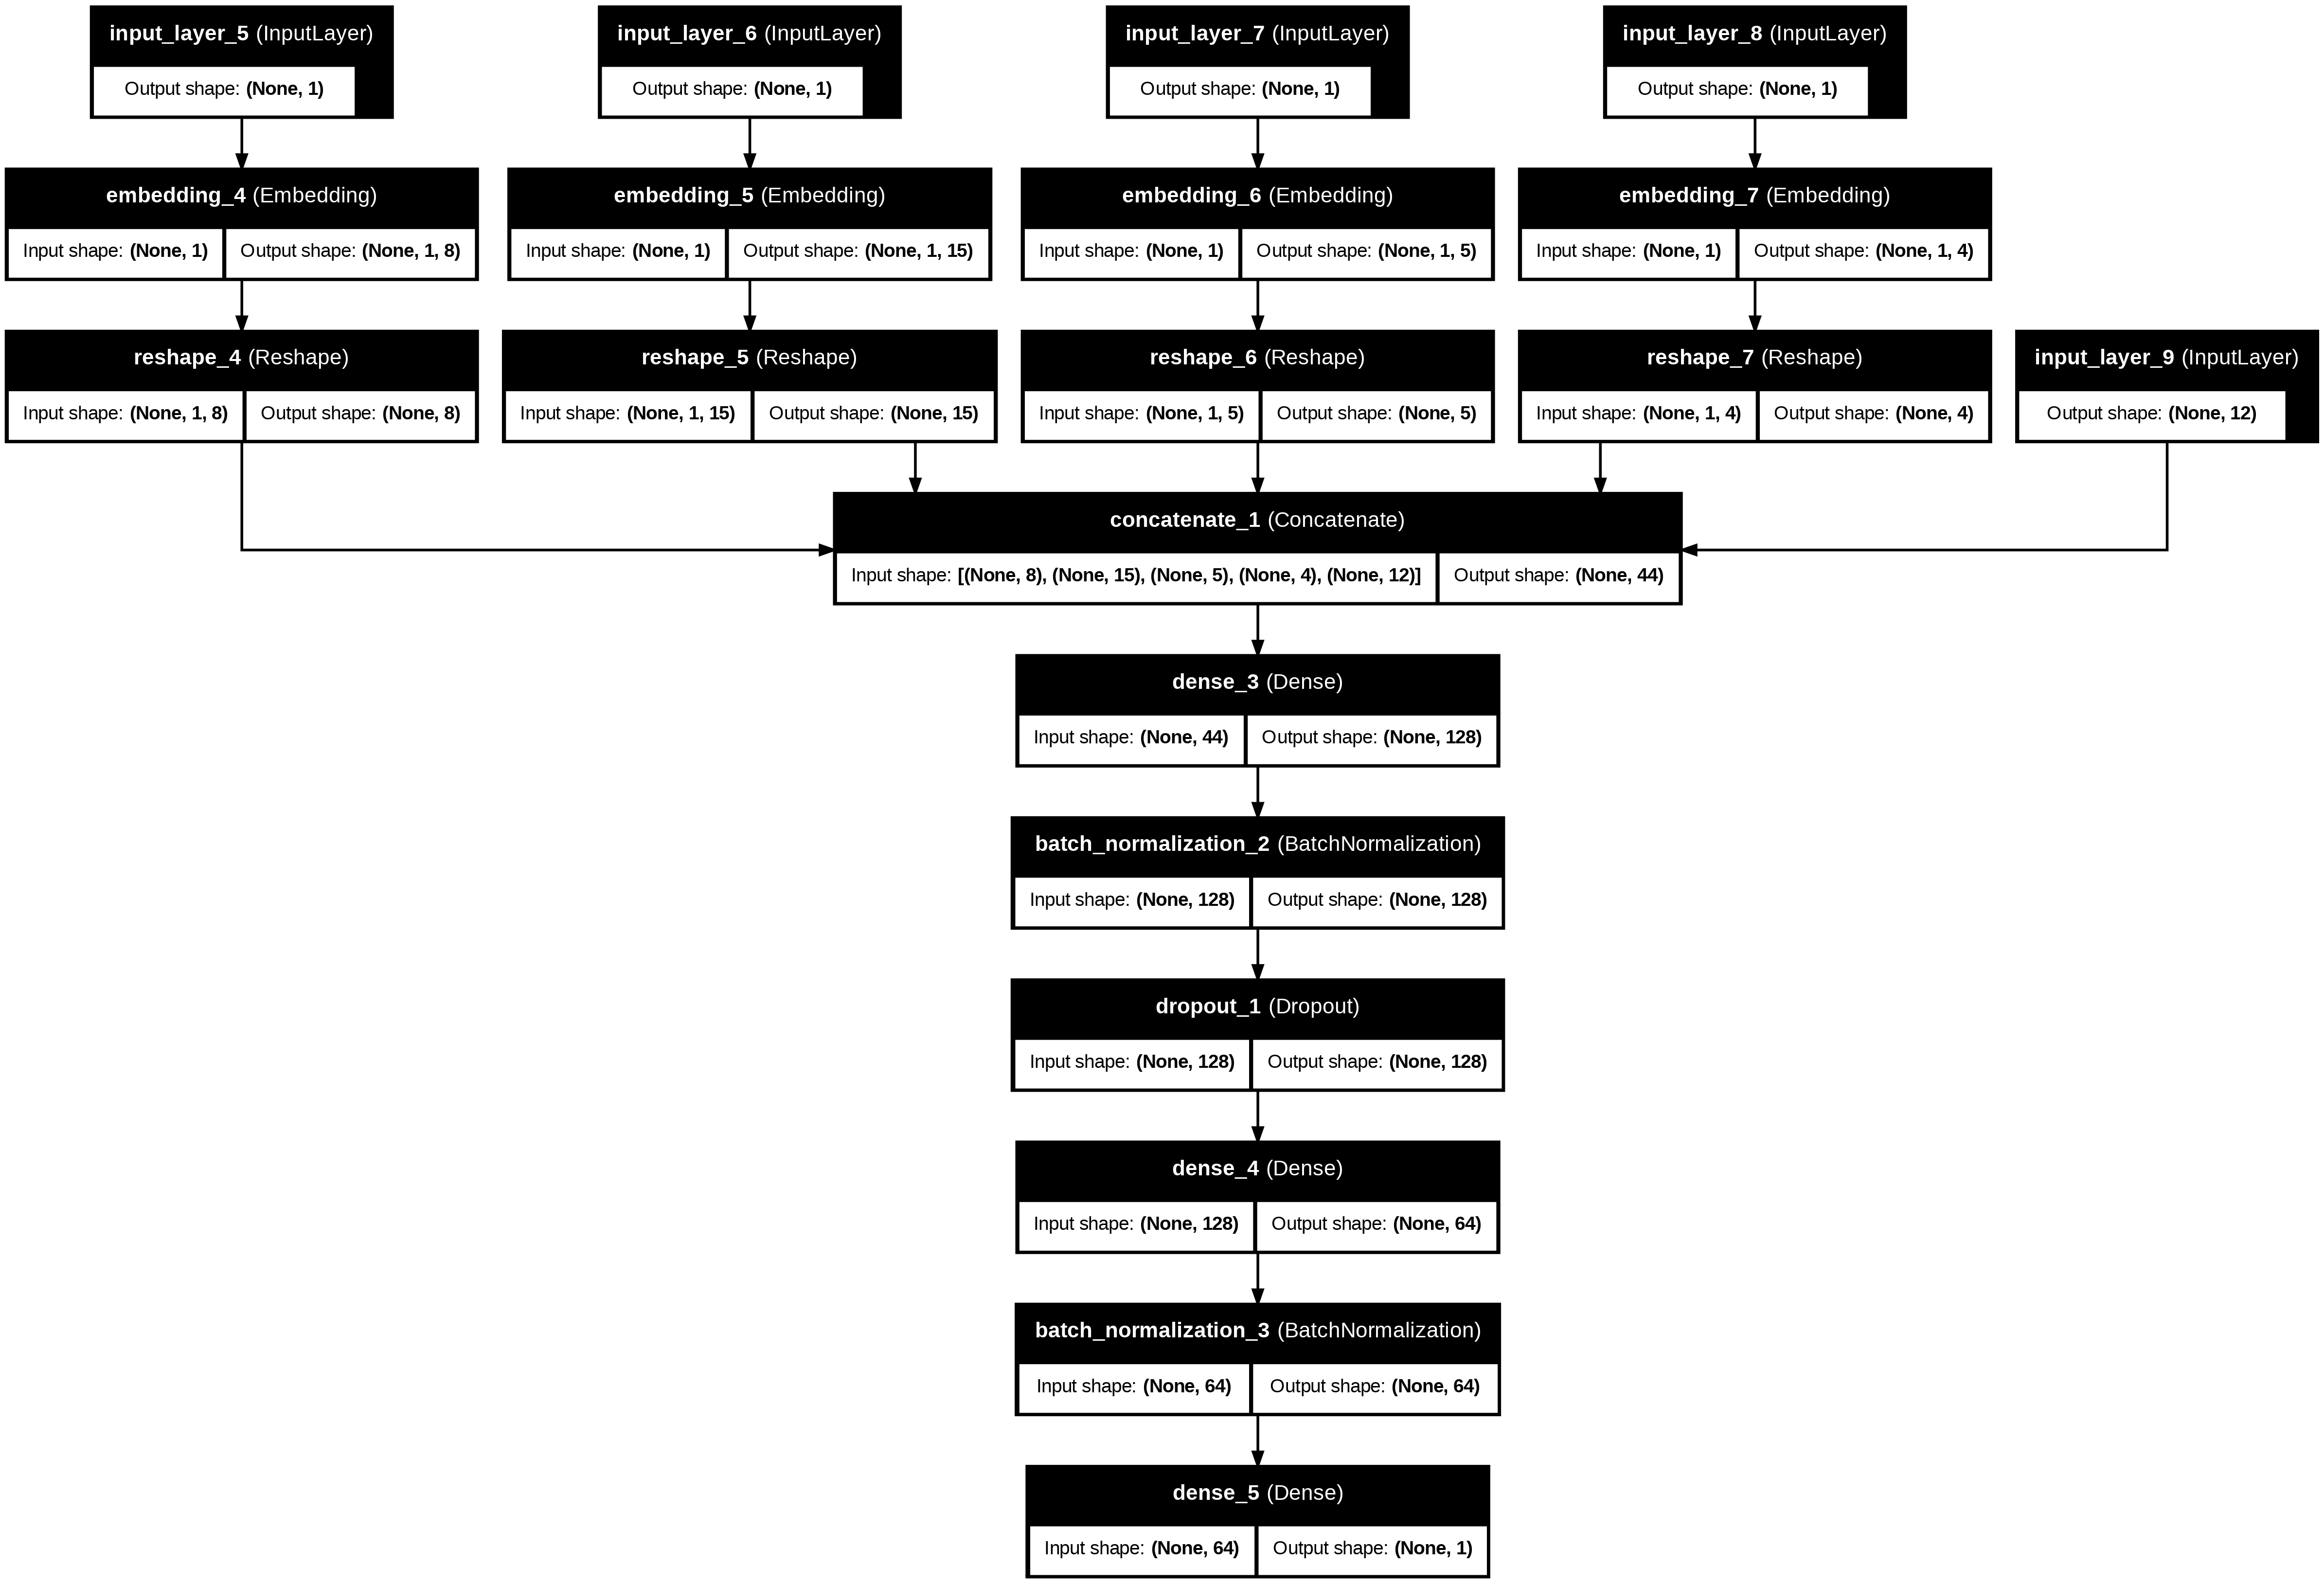

In [22]:
# Define embedding dimensions
n_unique_brand = len(np.unique(X_train_new['brand']))
n_unique_model = len(np.unique(X_train_new['model']))
n_unique_vehicleType = len(np.unique(X_train_new['vehicleType']))
n_unique_fuelType = len(np.unique(X_train_new['fuelType']))

input_brand = Input(shape=(1,))
emb_brand = Embedding(input_dim=n_unique_brand, output_dim=8)(input_brand)
emb_brand = Reshape(target_shape=(8,))(emb_brand)

input_model = Input(shape=(1,))
emb_model = Embedding(input_dim=n_unique_model, output_dim=15)(input_model)
emb_model = Reshape(target_shape=(15,))(emb_model)

input_vehicleType = Input(shape=(1,))
emb_vehicleType = Embedding(input_dim=n_unique_vehicleType, output_dim=5)(input_vehicleType)
emb_vehicleType = Reshape(target_shape=(5,))(emb_vehicleType)

input_fuelType = Input(shape=(1,))
emb_fuelType = Embedding(input_dim=n_unique_fuelType, output_dim=4)(input_fuelType)
emb_fuelType = Reshape(target_shape=(4,))(emb_fuelType)

input_numeric = Input(shape=(len(numeric_cols),))  # Includes rf_pred
emb_numeric = input_numeric

input_data = [input_brand, input_model, input_vehicleType, input_fuelType, input_numeric]
emb_data = [emb_brand, emb_model, emb_vehicleType, emb_fuelType, emb_numeric]

# Concatenate embeddings
model_data = Concatenate()(emb_data)

# Simplified MLP
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(model_data)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
outputs = Dense(1, activation='sigmoid')(x)

nn = Model(inputs=input_data, outputs=outputs, name='Stacked_RF_MLP')
print("\nTóm tắt mô hình MLP:")
nn.summary()
plot_model(nn, show_shapes=True, show_layer_names=True, to_file='Stacked_RF_MLP.png')
Image(retina=True, filename='Stacked_RF_MLP.png')

Cell 8: Train the MLP Model

Epoch 1/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 1.5036 - mae: 0.3387 - val_loss: 1.0426 - val_mae: 0.2945 - learning_rate: 5.0000e-04
Epoch 2/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.8986 - mae: 0.2049 - val_loss: 0.6382 - val_mae: 0.2478 - learning_rate: 5.0000e-04
Epoch 3/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.5331 - mae: 0.1428 - val_loss: 0.3876 - val_mae: 0.2174 - learning_rate: 5.0000e-04
Epoch 4/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.3093 - mae: 0.1053 - val_loss: 0.2359 - val_mae: 0.1954 - learning_rate: 5.0000e-04
Epoch 5/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1764 - mae: 0.0800 - val_loss: 0.1443 - val_mae: 0.1731 - learning_rate: 5.0000e-04
Epoch 6/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1001 - mae: 0.0658 - val_loss: 0.0920 - val_mae: 0.1560 - learning_rate: 5.0000e-04
Epoch 7/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0571 - mae: 0.0563 - val_loss: 0.0612 - val_mae: 0.1393 - lear

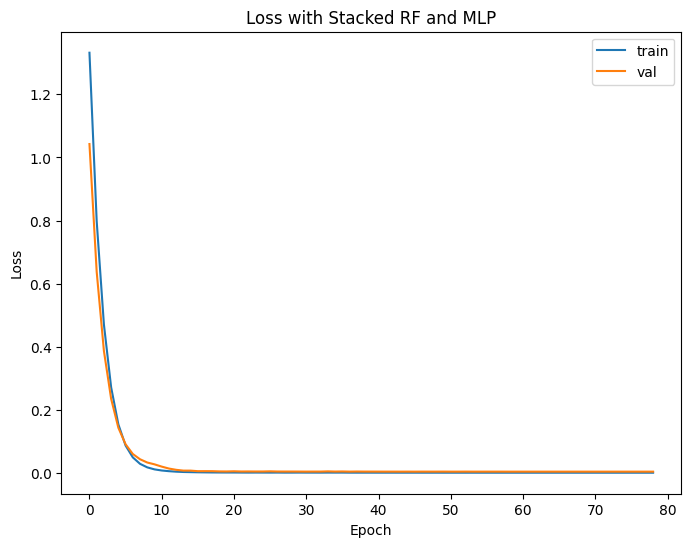

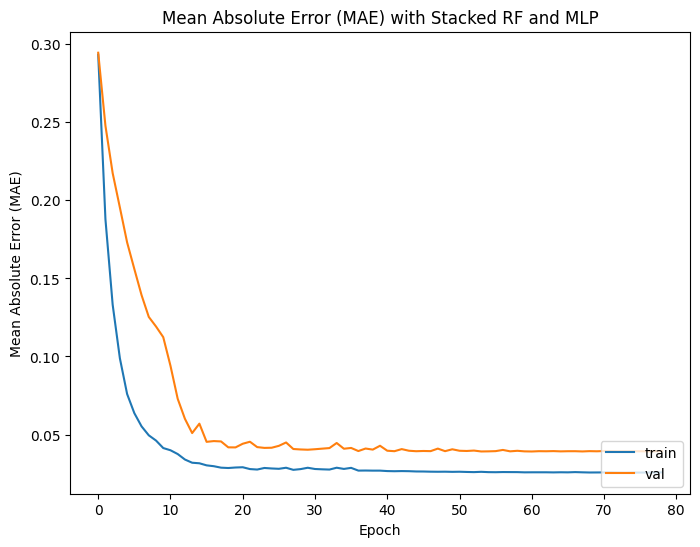

In [23]:
# Compile with gradient clipping and lower learning rate
nn.compile(
    loss='mean_squared_error',
    optimizer=Adam(learning_rate=0.0005, clipnorm=1.0),  # Even lower LR
    metrics=['mae']
)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-06)

history = nn.fit(
    input_list_train_new,
    y_train_new,
    validation_data=(input_list_val, y_val),
    epochs=150,
    batch_size=512,
    verbose=1,
    callbacks=[es, lr_scheduler]
)

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss with Stacked RF and MLP')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Mean Absolute Error (MAE) with Stacked RF and MLP')
plt.ylabel('Mean Absolute Error (MAE)')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

Cell 8 Enhanced

Cell 9: Evaluate the Stacked Model

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Evaluation Metrics:
                Random       Naive_Mean              RF  Stacked_MLP
MSE   308440355.600216  49163135.844137  6972178.501971    6906171.5
RMSE      17562.470088      7011.642878     2640.488307  2627.959473
MAE       14585.391932       4927.42914     1426.660841  1435.090698
R2           -5.278238        -0.000705        0.858083     0.859426
MAPE        733.121674       191.336241       37.340935    40.005696


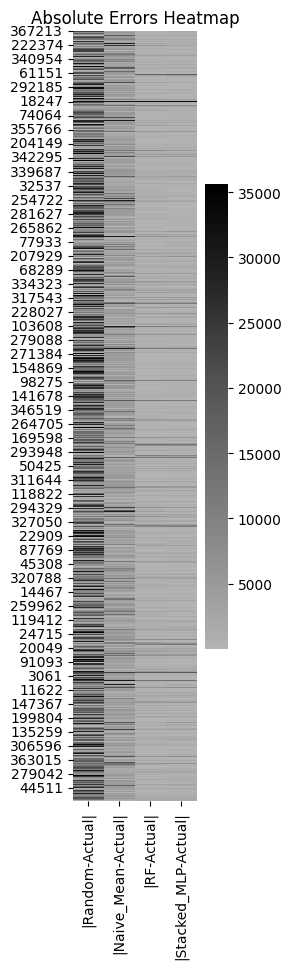

In [27]:
# MLP predictions
y_test_predict_mlp = nn.predict(input_list_test)
y_test_predict_mlp = np.clip(y_test_predict_mlp, 0, 1)
y_test_predict_mlp = price_scaler.inverse_transform(y_test_predict_mlp).flatten()

# RF predictions (for comparison)
y_test_predict_rf = rf_pred_test
y_test_predict_rf = np.clip(y_test_predict_rf, 0, 1)
y_test_predict_rf = price_scaler.inverse_transform(y_test_predict_rf.reshape(-1, 1)).flatten()

# Inverse transform y_test (fixed)
y_test_original = price_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Create results DataFrame
result_df = pd.DataFrame(index=X_test.index, columns=['Random', 'Naive_Mean', 'RF', 'Stacked_MLP', 'Actual'])
result_df['Actual'] = y_test_original
result_df['Naive_Mean'] = price_scaler.inverse_transform(np.full((len(y_test), 1), y_train.mean())).flatten()
result_df['Random'] = price_scaler.inverse_transform(np.random.uniform(y_train.min(), y_train.max(), len(y_test)).reshape(-1, 1)).flatten()
result_df['RF'] = y_test_predict_rf
result_df['Stacked_MLP'] = y_test_predict_mlp

# Calculate metrics
metric_df = pd.DataFrame(index=['MSE', 'RMSE', 'MAE', 'R2', 'MAPE'], columns=['Random', 'Naive_Mean', 'RF', 'Stacked_MLP'])
n_test = len(result_df)

for m in metric_df.columns:
    metric_df.at['MSE', m] = np.sum((result_df['Actual'] - result_df[m])**2) / n_test
    metric_df.at['RMSE', m] = np.sqrt(metric_df.at['MSE', m])
    metric_df.at['MAE', m] = np.sum(abs(result_df['Actual'] - result_df[m])) / n_test
    ss_tot = np.sum((result_df['Actual'] - result_df['Actual'].mean())**2)
    ss_res = np.sum((result_df['Actual'] - result_df[m])**2)
    metric_df.at['R2', m] = 1 - ss_res / ss_tot if ss_tot != 0 else 0
    non_zero_mask = result_df['Actual'] != 0
    metric_df.at['MAPE', m] = np.sum(np.abs(result_df['Actual'][non_zero_mask] - result_df[m][non_zero_mask]) / np.maximum(result_df['Actual'][non_zero_mask], 1000)) / non_zero_mask.sum() * 100

print("Evaluation Metrics:")
print(metric_df)

# Heatmap of absolute errors
for m in ['Random', 'Naive_Mean', 'RF', 'Stacked_MLP']:
    result_df[f'|{m}-Actual|'] = abs(result_df[m] - result_df['Actual'])

table = result_df[['|Random-Actual|', '|Naive_Mean-Actual|', '|RF-Actual|', '|Stacked_MLP-Actual|']]
plt.figure(figsize=(2, 10))
sns.heatmap(table, center=table.mean().mean(), cmap="Greys")
plt.title('Absolute Errors Heatmap')
plt.show()